**Importing Necessary Libraries**

In [2]:
# Utility
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

**Importing Data**

In [5]:
df = pd.read_csv('/kaggle/input/cyberbulling-tweets/cyberbullying_tweets.csv')

In [6]:
display(df.sample(5))

,tweet_text,cyberbullying_type
16270,If you open the quran you can read the violent...,religion
17433,Mam check out the UN list of terrorist u will ...,religion
17854,"Unfortunately the population of India is huge,...",religion
32204,My son and friends were bullied by a girl for ...,age
3082,@GarryBoyle40 @EamonnHolmes Thats exactly wha...,not_cyberbullying


In [7]:
df.shape

(47692, 2)

In [8]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [9]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

@DonewithBots @RRiffner @PolitiBunny keep ranting &amp; attacking people. You are making no points. Bye ✋ feminazi 😂 what a fool

I hate pregnant females they just be so mad Ima call her a bitch when she drop the baby though

Shut the fuck up you dumb nigger. Never tweet again or the clan will get you, you chicken loving ape.

@CheckItCool @CriticalKaiju U realize QuestionsForMen existed before Ford started posting snide crap in it, right? http://t.co/EaKt1gODFy

@adamseeley1997 @TotalerReinfall @Dweller_Of_Anus you are so damn retarded what the fuck is wrong with you. I mean damn nigger how dumb



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [11]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


**Data Pre-processing**

In [12]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [13]:
df['tweet_text'].duplicated().sum()

1675

In [14]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)

In [15]:
df['tweet_text'].duplicated().sum()

0

In [16]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

Looks pretty balanced.

Since the **other_cyberbullying** class is too generic, contains many categories in itself and brings down the accuracies of the upcoming prediction models, I have decided to remove it and work with the remaining classes.



In [17]:
df = df[df["cyberbullying_type"] != "other_cyberbullying"]
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity'],
      dtype=object)

In [18]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)

In [19]:
df.sample(10)

,tweet_text,cyberbullying_type
36238,Fam you used to bully me in middle school for ...,3
17572,Worm of Islamic militant http://jihad.my langu...,2
10467,RT @missgypsyck: Sassy.. More like trashy #MKR...,1
10386,If I was an independant like I was 6 years ago...,1
9013,Nick makes rape jokes and hangs out with weird...,1
21960,Some of your influencers are bunch of idiots. ...,2
5482,@buttercupashby @MaDaSaHaTtEr_17 You run your ...,0
7264,Fashion by Randi.,0
3864,@_DirtyTruths The first one seems to come from...,0
23238,@IAmThe1Teacher @IronmanL1 @stevecorrales80 An...,2


Time to clean the tweets and process them to a new column

In [20]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()    # Using Lemmatizer instead of Stemmer

Below are the custom defined functions to deep clean the unprocessed tweets.
Their identifier names describe their working.

In [22]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)

def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words) 

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res

def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res

In [23]:
# Defining a custom tweet cleaning function
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

Time to apply this processing function to our dataset.

In [24]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)

In [25]:
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets
35795,I was a student athlete in high school. I was ...,3,student athlete high school cross country trac...
12305,RT @Lyall: Bosom flattering #NoMorePage3 t-shi...,1,bosom flattering tshirt profile pic
45163,"FUCK OUT MY MENTIONS YOU DUMB NIGGER ""@TeeJayB...",4,fuck mention dumb nigger teejaybruh nigga
388,@tpstigers it depends on how you define meanin...,0,depends define meaningful 3 people listen v 30...
38029,I hate that I love Taylor Swifts new album is ...,3,hate love taylor swift new album possible fan ...
44177,` some niggers is real dumb they buy cars and ...,4,nigger real dumb buy car truck cause bxtch loo...
858,RT @jcherkis: Thanks @Pahlkadot for the great ...,0,thanks great talk digital government
34543,it's always the girls who were the meanest in ...,3,always girl meanest high school becoming nurse...
17868,She is indeed sad and sick - but that is what ...,2,indeed sad sick happens rightwinger useful idi...
10841,"After Nancy Binay Skin Colour Puns, Gay Filipi...",1,nancy binay skin colour pun gay filipino comed...


The **clean_tweets** column holds the processed tweets.

It's nice and does the job, but we can do much better cleaning by using pre-defined functions and RegEx.
Therefore, I'm using the **tweet-preprocessor** library, as shown below.

In [26]:
!pip install tweet-preprocessor
import preprocessor as p

In [27]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

It takes care of all the URLs, Hashtags, Mentions, Reserved Words, Emojis and Smileys.

In [28]:
# Defining the better cleaning function
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [29]:
# Clean tweets
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets
18070,@tintinenameriq @MaxBlumenthal @Campagnebds Sh...,2,show stupid youve become muslim terrorist actu...
6190,Photo: Write about bullying. http://tumblr.com...,0,photo write bullying
31729,Except for the b***** next to me who have no e...,3,except b next etiquette bullied young middlehi...
23503,@Lithobolos @PoliticalAnt @ZaibatsuNews It's n...,2,specific individual ideaology always produce t...
34584,"He said he didnt care. But, am I crazy to susp...",3,said didnt care crazy suspect bill barr one fo...
4323,"No girls....you really, really can't win this ...",0,girlsyou really really cant win competition
11766,yeah he made some transphobic jokes about tran...,1,yeah made transphobic joke trans woman caitlyn...
2465,Thanks to everyone that came out to walk with ...,0,thanks everyone came walk u san benito bully d...
42302,"Idiot niggers, every fucking person with half ...",4,idiot nigger every fucking person half sense k...
2243,Drasko they didn't cook half a bird you idiot ...,0,drasko didnt cook half bird idiot


Checking again if any values got duplicated.

In [30]:
df['clean_tweets'].duplicated().sum()

1217

Removing them all.

In [31]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [32]:
df.shape

(38557, 3)

**38557** tweets are remaining.

Now that we have processed the tweets, it's time to move forward and calculate the total and average word lengths of each tweet.

In [33]:
# Total word count of a tweet
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets,word_count
21408,"800 years of slavery , rapes , killings , conv...",2,year slavery rape killing conversionsetc musli...,44
22124,When you ask these idiots about the plight of ...,2,ask idiot plight palestinian colonial aparthei...,48
10761,"both a ""huh huh you're a gay"" and a prison rap...",1,huh huh youre gay prison rape joke tweet,16
23642,Good kids feel safer with police in the school...,3,good kid feel safer police school kid dont lik...,26
24621,Right wing is the classic closeted gay footbal...,3,right wing classic closeted gay football team ...,26
3683,RT @GrumpyVancouver: @YesYoureSexist maybe so....,0,maybe still right,9
3336,@camilla__l opa é bulling,0,opa bulling,4
27156,@WE_R_MANY Dylan bullied a girl in high school...,3,dylan bullied girl high school committed suici...,52
24778,It's 7th grade. I was being bullied every day ...,3,th grade bullied every day group girl probably...,37
36915,"Anonymous said: Look at this filthy nigger, sm...",4,anonymous said look filthy nigger smh ya white...,18


In [34]:
# Average word length of a tweet
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
6058,Is it just us or is #ImACelebrityAU turning in...,0,u turning meet,13,4.54
30952,"@TheRebelTiger , @TheFantasyNinja , and I were...",4,arepa spot went check order inside white perso...,55,4.04
9266,shit dude call me a female dog then cos i’m a ...,1,shit dude call female dog co bitch,12,3.33
30166,"You're a bit of a dork, aren't you?",3,youre bit dork arent,8,3.50
1948,RT @thebolditalic: Repeatedly calling a woman ...,0,repeatedly calling woman bitch stage part crun...,21,5.71


**Data Visualization**

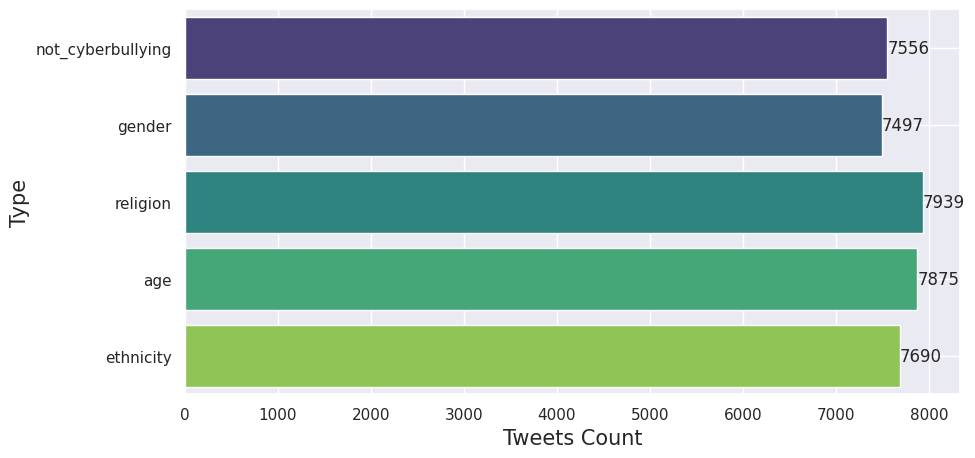

In [35]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

All the classes look balanced.

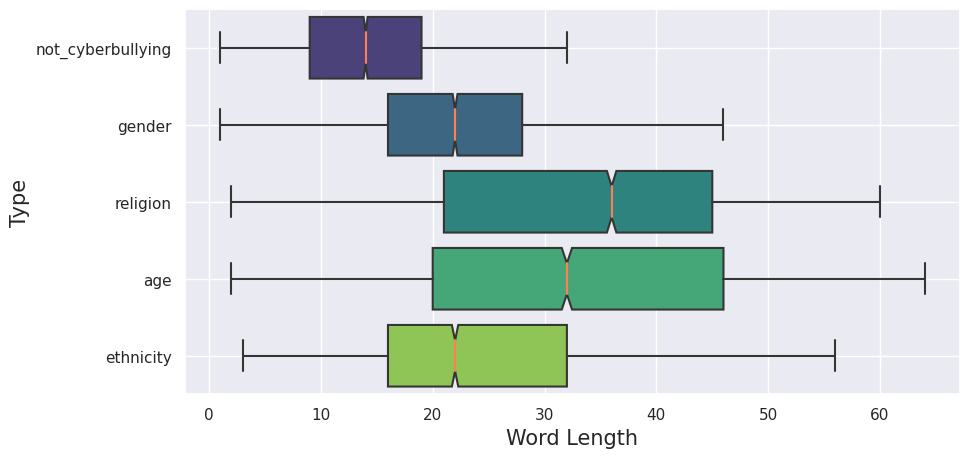

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

We can observe that the tweets targeted towards a gender tend to have a bit less words in them than say, the ones targeted towards religion.
But overall, a bullying tweet has more words in it and is more varied than a normal one.

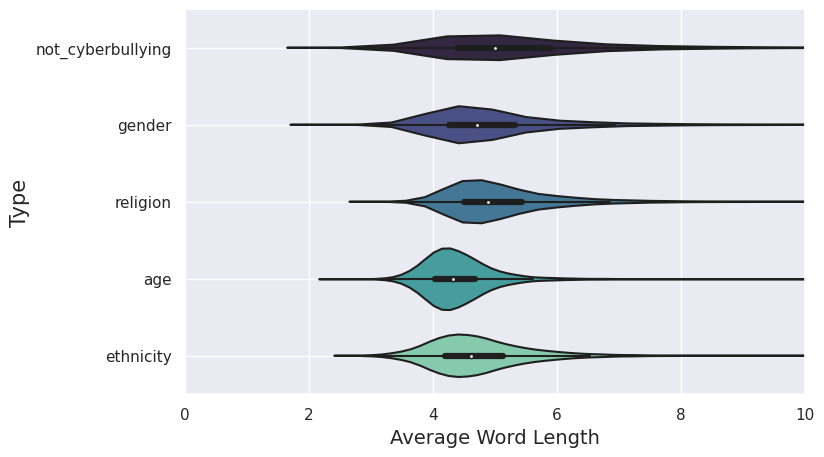

In [37]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Pretty much the same for all, between 4 to 6 letters.

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

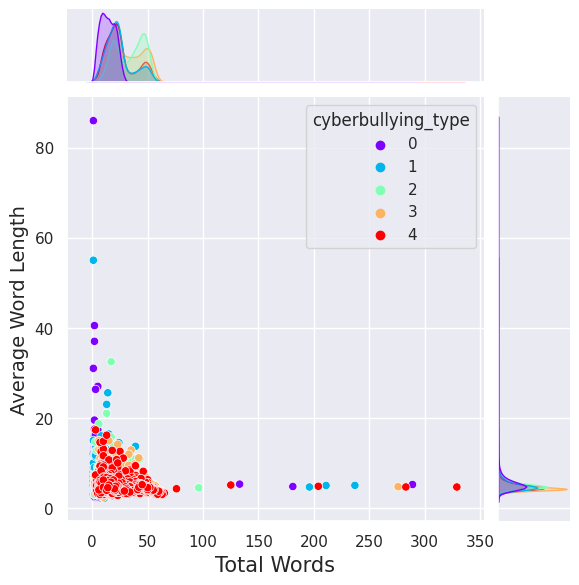

In [38]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

**Word clouds**

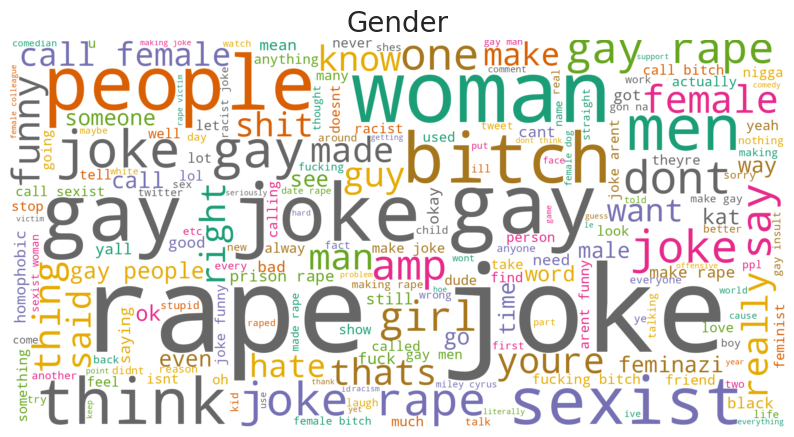

In [39]:
# Gender
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_tweets'].values
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))

plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')

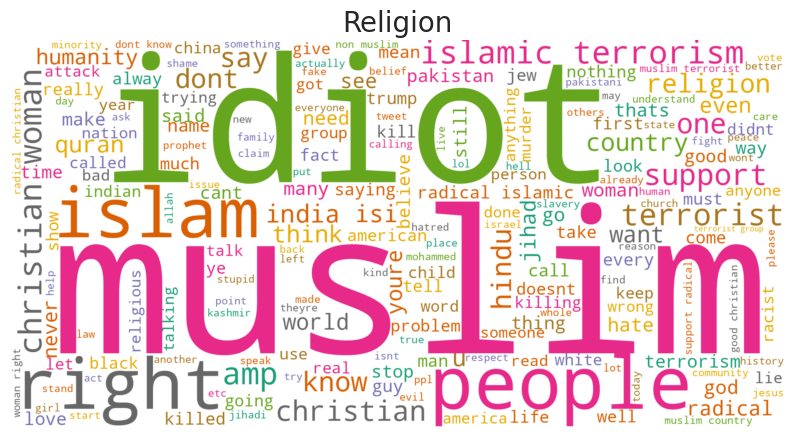

In [40]:
# Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

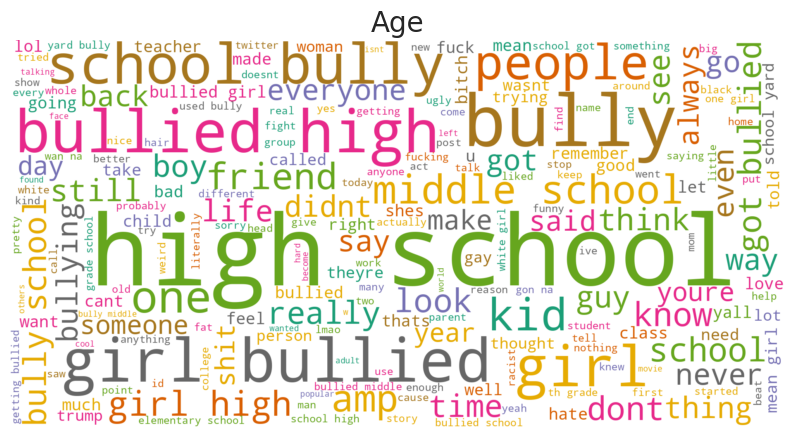

In [41]:
# Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

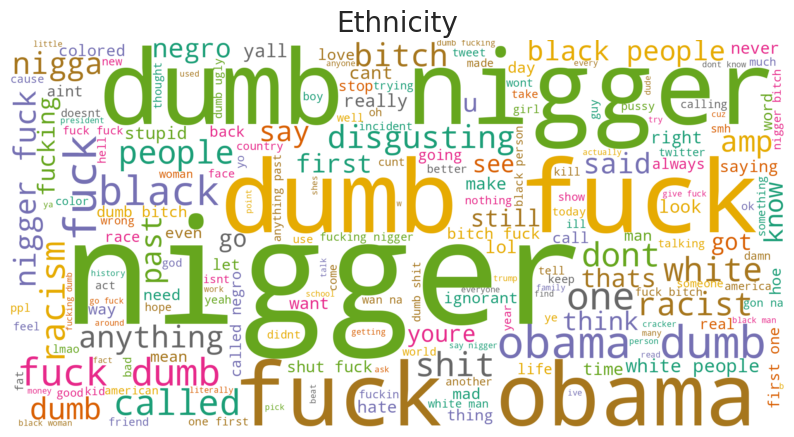

In [42]:
# Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

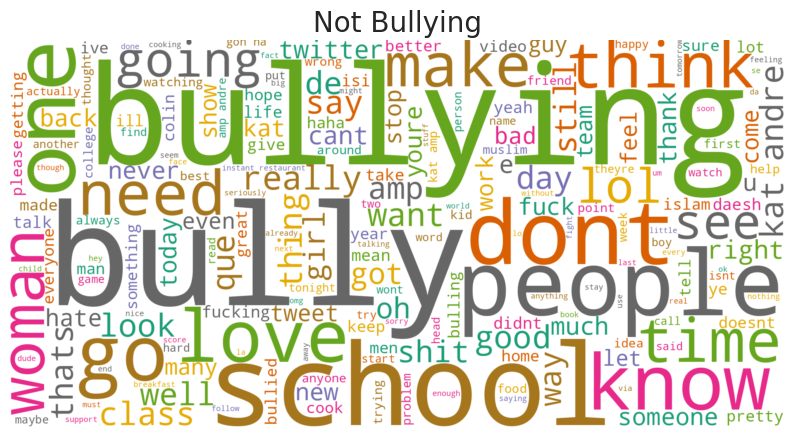

In [43]:
# Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

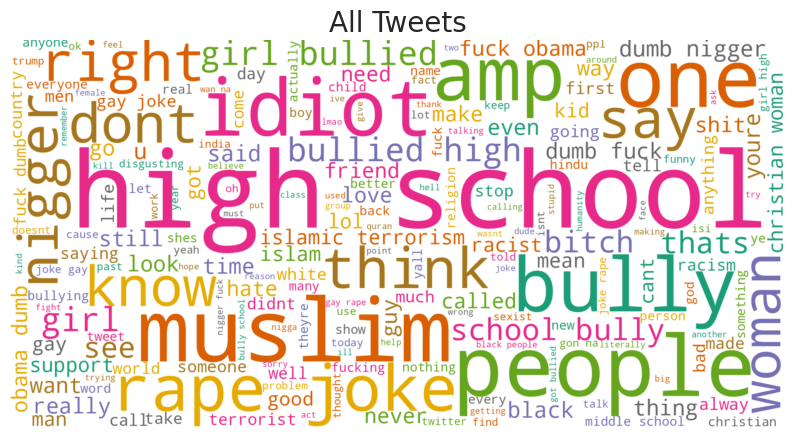

In [44]:
# All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

Now that we're done with the wordclouds, let's check which words are the most popular.

In [45]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 38618
[('word', 870), ('food', 128), ('crapilicious', 1), ('white', 2219), ('classy', 29)]


**vocab** contains the frequency of all the unique words in the whole dataset. Pretty interesting.
Let's try to plot it and see what we get.

In [46]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

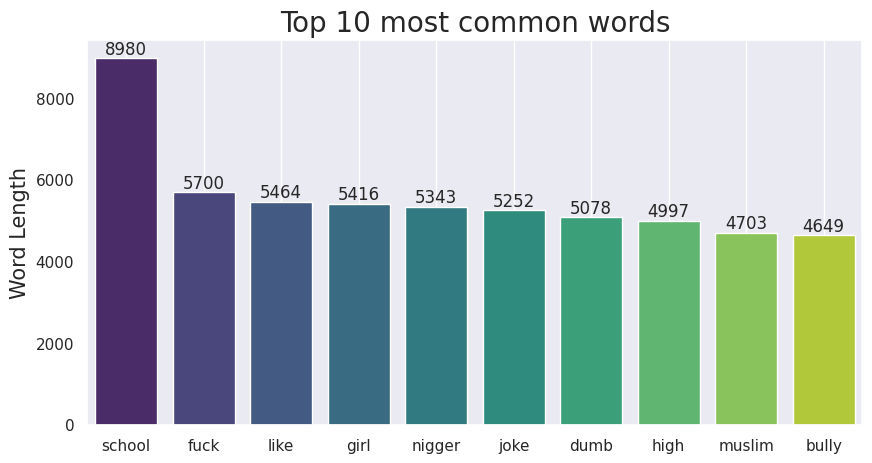

In [47]:
# Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [50]:
df

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
0,"In other words #katandandre, your food was cra...",0,word food crapilicious,9,5.89
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,white,14,7.29
2,@XochitlSuckkks a classy whore? Or more red ve...,0,classy whore red velvet cupcake,9,5.78
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,meh thanks head concerned another angry dude t...,18,4.72
4,@RudhoeEnglish This is an ISIS account pretend...,0,isi account pretending kurdish account like is...,18,4.72
...,...,...,...,...,...
38552,"Black ppl aren't expected to do anything, depe...",4,black ppl arent expected anything depended any...,42,4.60
38553,Turner did not withhold his disappointment. Tu...,4,turner withhold disappointment turner called c...,45,5.16
38554,I swear to God. This dumb nigger bitch. I have...,4,swear god dumb nigger bitch got bleach hair re...,20,4.25
38555,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,4,yea fuck youre nigger fucking unfollow fucking...,15,5.07


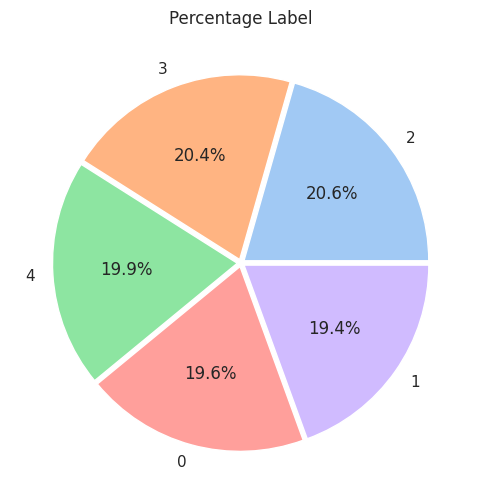

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

label_count = df['cyberbullying_type'].value_counts()

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02] * len(label_count)

plt.figure(figsize=(10, 6))
plt.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
plt.title('Percentage Label')
plt.show()

**Named Entity Recognition (NER) Plot**

In [54]:
import spacy
from spacy import displacy

In [53]:
#sample text
text = df['tweet_text'].iloc[4]

#load pre-trained NER model
nlp = spacy.load('en_core_web_sm')

#perform named entity recognition
doc = nlp(text)

#visualize named entities
displacy.render(doc, style='ent', jupyter=True)

**Part-of-Speech (POS) Tagging Plot**

In [55]:
#sample text
text = df['tweet_text'].iloc[1]

#load pre-trained POS tagging model
nlp = spacy.load('en_core_web_sm')

#perform POS tagging
doc = nlp(text)

#visualize POS tagging
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})